In [1]:
import tensorflow as tf
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
sess = tf.compat.v1.Session(config=config)

physical_devices = tf.config.experimental.list_physical_devices('GPU')
if len(physical_devices) > 0:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)

2022-10-05 14:42:50.763886: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-10-05 14:42:51.677979: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-10-05 14:42:54.117922: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/home/tharci/anaconda3/lib/
2022-10-05 14:42:54.121487: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: c

In [9]:
from __future__ import print_function
import numpy
from tensorflow import keras
from keras.datasets import mnist
from keras import backend as K
from matplotlib import pyplot as plt
import numpy as np
import tensorflow_federated as tff
import cv2

import matplotlib.pyplot as plt
plt.gray()

<Figure size 432x288 with 0 Axes>

In [3]:
seed = 123
zoom = 2
downscale_fact = 2

image_height_orig = 720
image_width_orig = 1280

image_height_ds = image_height_orig // downscale_fact
image_width_ds = image_width_orig // downscale_fact

image_height = 200
image_width = 200

images_path = '../images'
batch_size = 32

train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    # shear_range=0.2,
    # zoom_range=zoom_range,
    # horizontal_flip=True,
    validation_split=0.2,
)

train_ds = train_datagen.flow_from_directory(
    images_path,
    target_size=(image_height_ds, image_width_ds),
    batch_size=batch_size,
    color_mode='grayscale',
    class_mode=None,
    subset='training'
)

test_ds = train_datagen.flow_from_directory(
    images_path,
    target_size=(image_height_ds, image_width_ds),
    batch_size=batch_size,
    color_mode='grayscale',
    class_mode=None,
    subset='validation'
)


def preprocess_img(img):
    y = np.random.randint(0, img.shape[0] - image_height)
    x = np.random.randint(0, img.shape[1] - image_width)
    return img[y:y+image_height, x:x+image_width]


def preprocess_generator(generator):
    while True:
        batch = next(generator)
        batch_crops = np.zeros((batch.shape[0], image_height, image_width, 1))
        for i in range(batch.shape[0]):
            batch_crops[i] = preprocess_img(batch[i])
        yield batch_crops, batch_crops

train_ds_prep = preprocess_generator(train_ds)
test_ds_prep = preprocess_generator(test_ds)

# train_ds_mapped = pair_mapping(train_ds)
# test_ds_mapped = pair_mapping(test_ds)



Found 3407 images belonging to 1 classes.
Found 851 images belonging to 1 classes.


In [4]:
print(train_ds_prep)
print(np.max(next(train_ds_prep)[0]))
print('asd', next(train_ds_prep)[0].shape)
print('asd', next(train_ds_prep)[1].shape)
train_ds.reset()

<generator object preprocess_generator at 0x7fc6045c3ac0>
1.0
asd (32, 200, 200, 1)
asd (32, 200, 200, 1)


<Figure size 432x288 with 0 Axes>

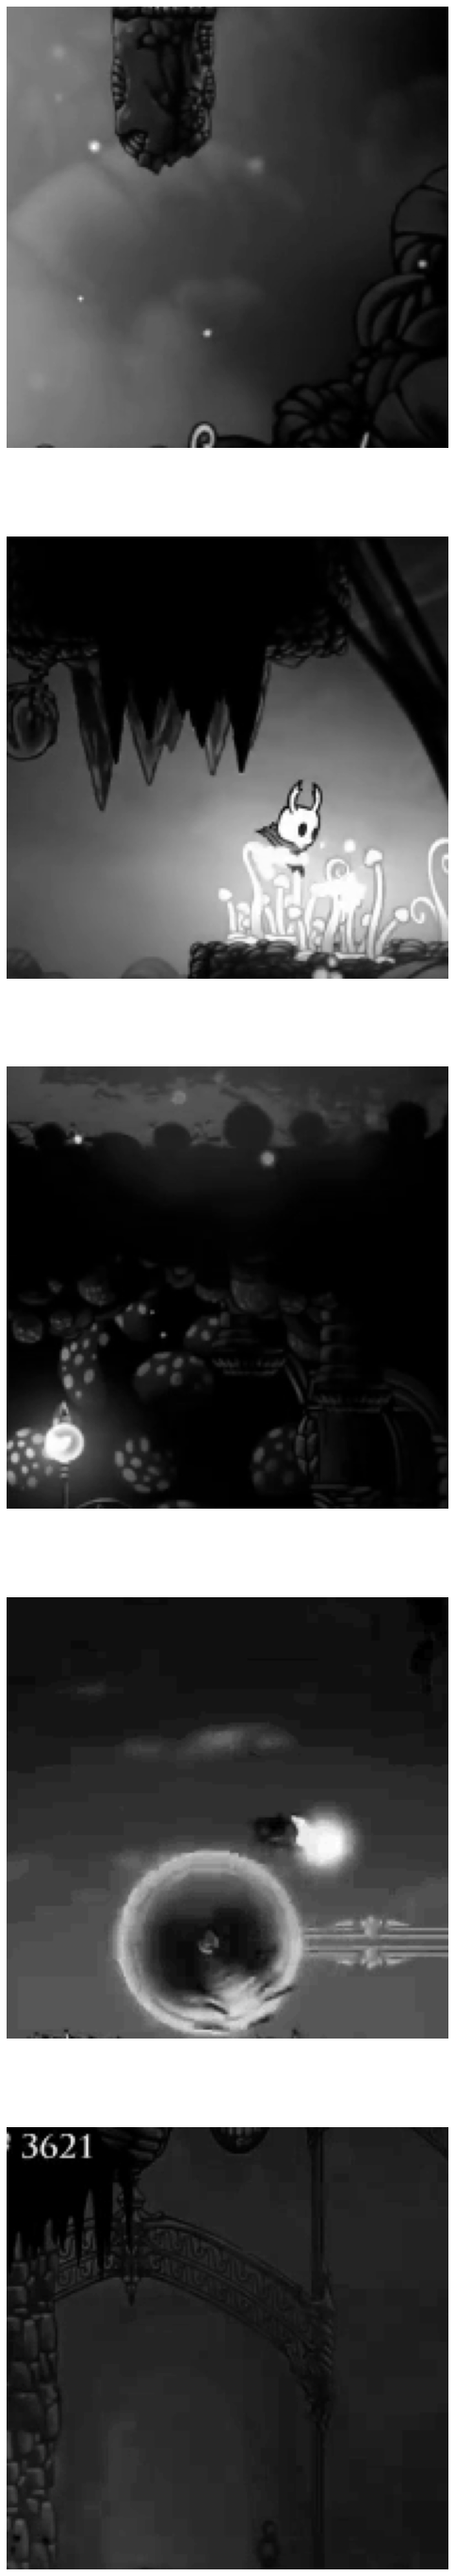

In [5]:
plt.figure(figsize=(50, 50))
images = next(train_ds_prep)
for i, image in enumerate(images[0][:5]):
    ax = plt.subplot(5, 1, i + 1)
    plt.imshow(image)
    plt.axis("off")

train_ds.reset()

In [5]:
import tensorflow
from tensorflow.keras import mixed_precision
from tensorflow.keras import backend as K, losses
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Activation, ZeroPadding2D, Dropout, BatchNormalization, Conv2DTranspose
from tensorflow.keras.layers import UpSampling2D
from tensorflow.keras.models import Model, Sequential
from keras.regularizers import l2


def ssim_loss(y_true, y_pred):
    return 1 - tensorflow.reduce_mean(tensorflow.image.ssim_multiscale(y_true, y_pred, 1.0, filter_size=3))

def create_big_compression_model_2(image_width, image_height):
    model = Sequential([
        Conv2D(input_shape=(image_width, image_height, 1), filters=16, kernel_size=(4, 4), activation='relu', padding='same'),
        MaxPooling2D((3, 3)),
        Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same'),
        #Dropout(.2),
        MaxPooling2D((2, 2)),
        Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same'),
        #Dropout(.2),
        MaxPooling2D((2, 2), name='encoded', dtype='float16'),
        #Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same'),
        #Dropout(.2),
        #MaxPooling2D((2, 2), name='encoded', dtype='float16'),

        #Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same'),
        #UpSampling2D((2, 2)),
        Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same'),
        #Dropout(.2),
        UpSampling2D((2, 2)),
        ZeroPadding2D(((1, 0), (1, 0))),
        Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same'),
        #Dropout(.2),
        UpSampling2D((2, 2)),
        Conv2D(filters=16, kernel_size=(3, 3), activation='relu', padding='same'),
        UpSampling2D((3, 3)),
        ZeroPadding2D(((1, 1), (1, 1))),
        Conv2D(filters=1, kernel_size=(3, 3), padding='same', activation='sigmoid', name='decoded'),
    ])

    print(("shape of encoded", K.int_shape(model.get_layer('encoded').output)))
    print(("shape of decoded", K.int_shape(model.get_layer('decoded').output)))

    return model

def create_mnist_compression_model(image_width, image_height):
    tensorflow.random.set_seed(0)
    inputs = Input(shape=(image_width, image_height, 1))

    # Encoder (convolutional base)
    x = Conv2D(16, kernel_size=(3, 3), activation='relu', padding='same')(inputs)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same')(x)
    encoded = MaxPooling2D((2, 2), padding='same')(x)
    print(("shape of encoded", K.int_shape(encoded)))



    # Decoder (upsamling)
    x = Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same')(encoded)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same')(x)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(16, kernel_size=(3, 3), activation='relu', padding='same')(x)
    x = UpSampling2D((2, 2))(x)
    decoded = Conv2D(1, kernel_size=(5, 5), padding='same')(x)
    print(("shape of decoded", K.int_shape(decoded)))

    return Model(inputs, decoded)

def create_improved_baseline_model(image_width, image_height):
    model = Sequential()
    model.add(Conv2D(32, kernel_size=(3, 3), strides=(2, 2), activation='relu', kernel_initializer='he_normal', input_shape=(image_width, image_height, 1)))
    model.add(Conv2D(16, kernel_size=(3, 3), strides=(2, 2), activation='relu', kernel_initializer='he_normal'))
    model.add(Conv2D(16, kernel_size=(3, 3), strides=(2, 2), activation='relu', kernel_initializer='he_normal', name='encoded', dtype='float16'))
    model.add(Conv2DTranspose(16, kernel_size=(3,3), strides=(2, 2), activation='relu', kernel_initializer='he_normal'))
    model.add(Conv2DTranspose(16, kernel_size=(3,3), strides=(2, 2), activation='relu', kernel_initializer='he_normal'))
    model.add(Conv2DTranspose(32, kernel_size=(3,3), strides=(2, 2), activation='relu', kernel_initializer='he_normal'))
    model.add(ZeroPadding2D(((1, 0), (1, 0))))
    model.add(Conv2D(1, kernel_size=(3, 3), activation='sigmoid', padding='same', name='decoded'))

    print(("shape of encoded", K.int_shape(model.get_layer('encoded').output)))
    print(("shape of decoded", K.int_shape(model.get_layer('decoded').output)))

    return model

# mixed_precision.set_global_policy('mixed_float16')
# mixed_precision.set_global_policy('float32')

In [10]:
autoencoder = create_improved_baseline_model(image_width, image_height)
autoencoder.summary()
autoencoder.compile(optimizer=keras.optimizers.Adam(learning_rate=0.005), loss=ssim_loss)
# autoencoder.compile(optimizer=keras.optimizers.SGD(learning_rate=0.05), loss=ssim_loss)

('shape of encoded', (None, 24, 24, 16))
('shape of decoded', (None, 200, 200, 1))
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 99, 99, 32)        320       
                                                                 
 conv2d_7 (Conv2D)           (None, 49, 49, 16)        4624      
                                                                 
 encoded (Conv2D)            (None, 24, 24, 16)        2320      
                                                                 
 conv2d_transpose (Conv2DTra  (None, 49, 49, 16)       2320      
 nspose)                                                         
                                                                 
 conv2d_transpose_1 (Conv2DT  (None, 99, 99, 16)       2320      
 ranspose)                                                       
                                     

In [22]:
# loss: 0.0676 - val_loss: 0.0727
# after 160 epochs - loss 0.0392

# 4x
# loss: 60 epochs - 0.1301
# loss: > 1000 epochs - 0.0784
# autoencoder.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001), loss=losses.MeanAbsoluteError())
# autoencoder.compile(optimizer=keras.optimizers.Adam(learning_rate=0.003), loss=losses.MeanSquaredError())
autoencoder.fit(train_ds_prep,
                validation_data = test_ds_prep,
                steps_per_epoch = train_ds.n // train_ds.batch_size,
                validation_steps = test_ds.n // test_ds.batch_size,
                epochs=100,
                verbose=1)

# autoencoder.fit(train_ds_mapped, epochs=1,
#                 validation_data=test_ds_mapped, verbose=1)

Epoch 1/100
106/106 [==============================] - 44s 413ms/step - loss: 0.0082 - val_loss: 0.0079
Epoch 2/100
106/106 [==============================] - 43s 411ms/step - loss: 0.0078 - val_loss: 0.0077
Epoch 3/100
106/106 [==============================] - 44s 418ms/step - loss: 0.0082 - val_loss: 0.0077
Epoch 4/100
106/106 [==============================] - 43s 410ms/step - loss: 0.0079 - val_loss: 0.0078
Epoch 5/100
106/106 [==============================] - 43s 413ms/step - loss: 0.0077 - val_loss: 0.0086
Epoch 6/100
106/106 [==============================] - 44s 412ms/step - loss: 0.0076 - val_loss: 0.0075
Epoch 7/100
106/106 [==============================] - 44s 414ms/step - loss: 0.0078 - val_loss: 0.0078
Epoch 8/100
106/106 [==============================] - 43s 409ms/step - loss: 0.0079 - val_loss: 0.0076
Epoch 9/100
106/106 [==============================] - 43s 412ms/step - loss: 0.0081 - val_loss: 0.0074
Epoch 10/100
106/106 [==============================] - 43s 409m

In [25]:
autoencoder.save('../model-saves/tmp/')

INFO:tensorflow:Assets written to: ../model-saves/tmp/model-save-170/assets


INFO:tensorflow:Assets written to: ../model-saves/tmp/model-save-170/assets


In [7]:
autoencoder = keras.models.load_model('../model-saves/conv2dtrans/model-save-170', custom_objects={
    'ssim_loss': ssim_loss
})

1/1 [==============================] - 0s 132ms/step


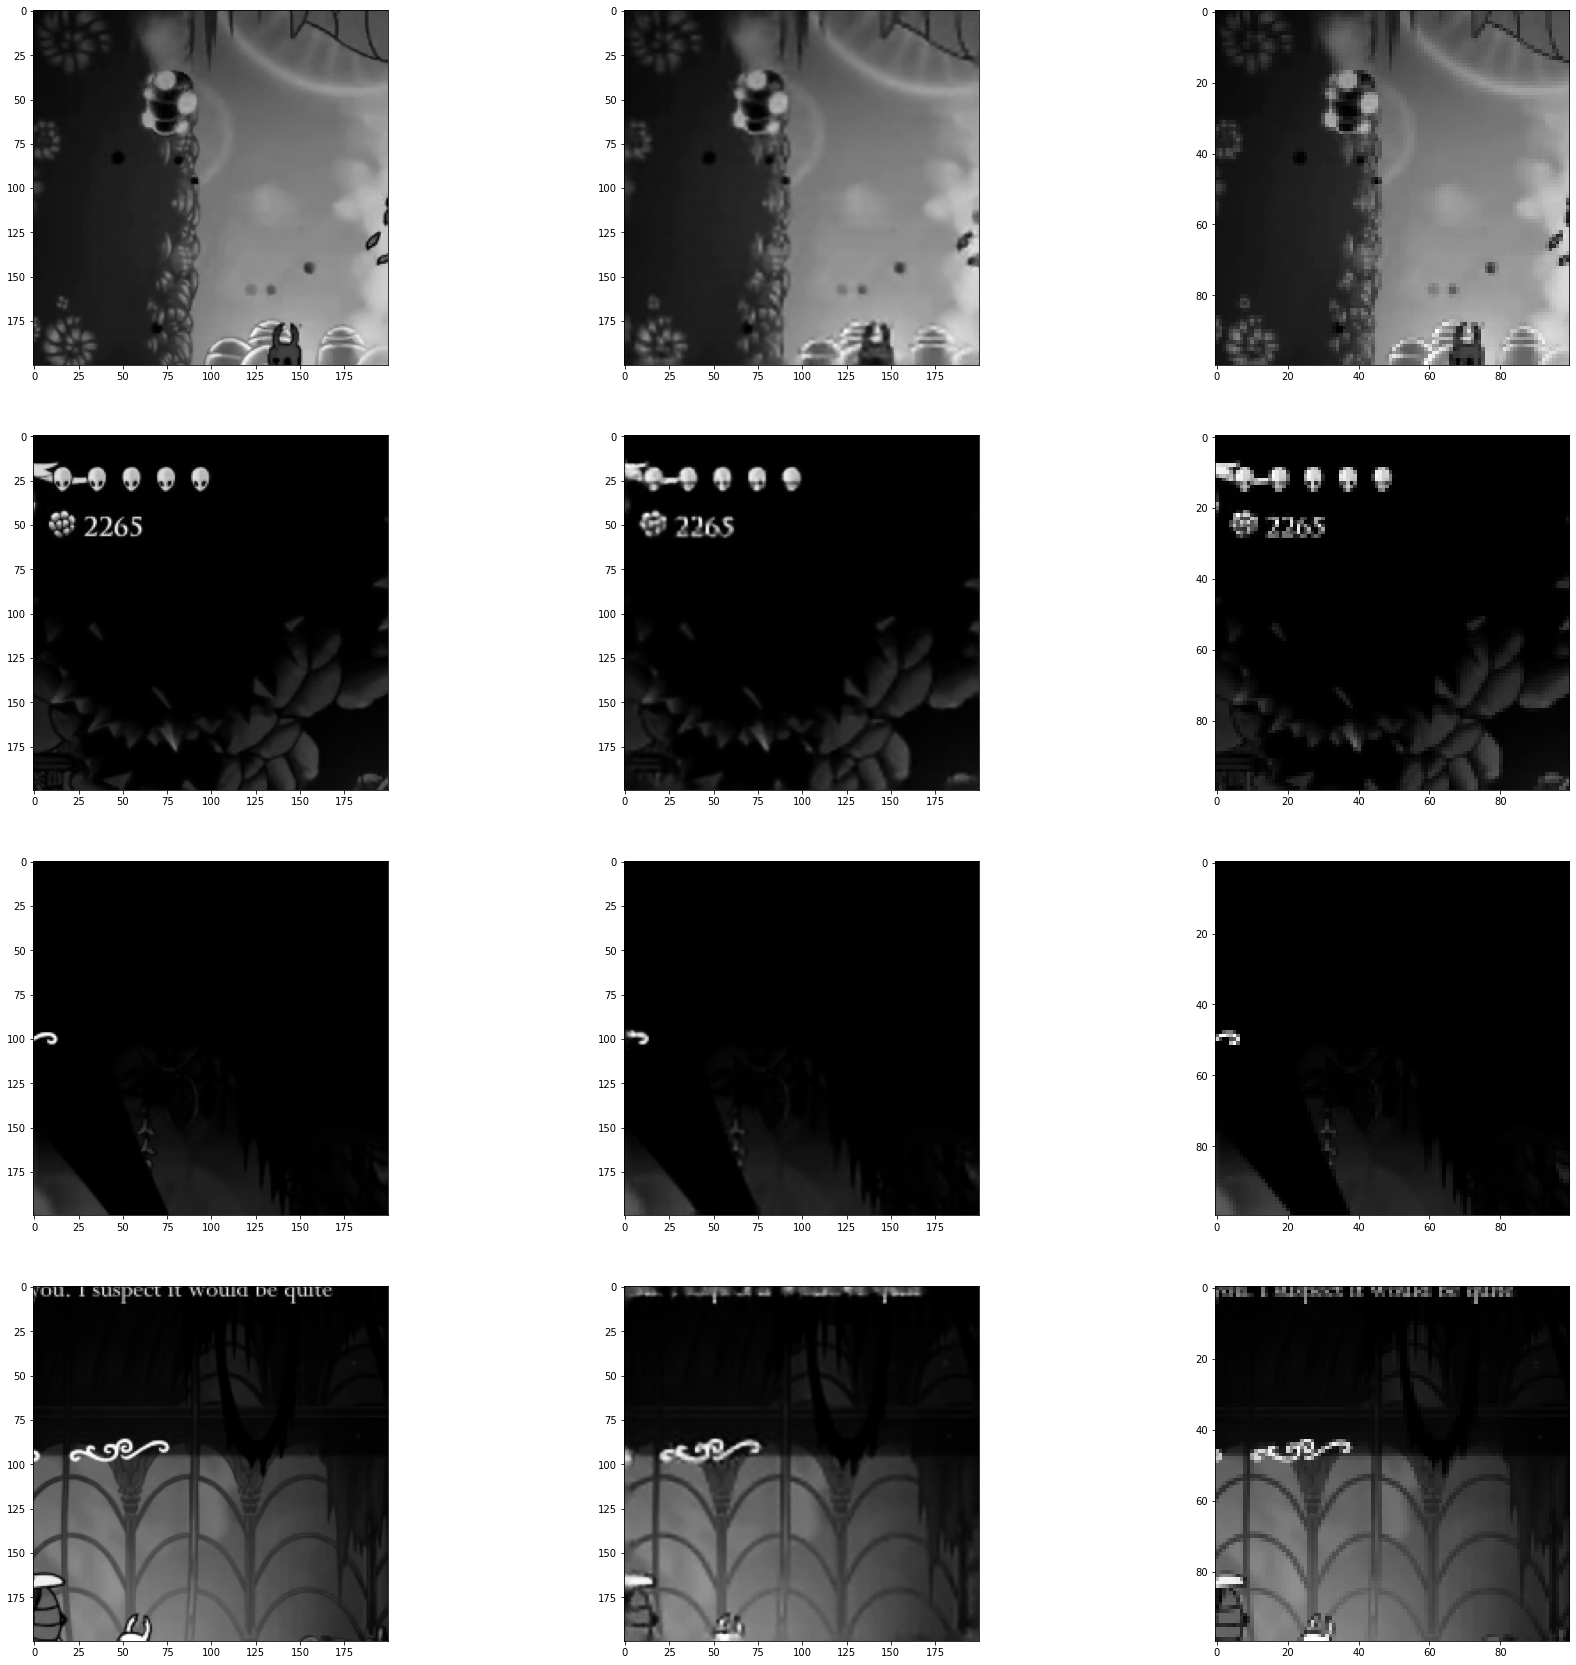

In [12]:
from matplotlib.pyplot import axes
import numpy as np

img_number = 4
test_images = next(test_ds_prep)[0][:img_number]
decoded_imgs = autoencoder.predict(test_images)

fig = plt.figure(figsize=(30, 30))

for i, in_img, out_img in zip(range(0, img_number, 1), test_images, decoded_imgs):
    plt.subplot(img_number, 3, i*3+1)
    plt.imshow(in_img)
    plt.subplot(img_number, 3, i*3 + 2)
    plt.imshow(out_img)
    plt.subplot(img_number, 3, i*3 + 3)
    rescaled_img = cv2.resize(in_img, (in_img.shape[0] // 2, in_img.shape[1] // 2))
    # manual_compression = tensorflow.cast(in_img*255. ,tensorflow.int32)
    # manual_compression = manual_compression - (manual_compression % 64)
    # manual_compression = tensorflow.cast(manual_compression ,tensorflow.float32)
    # manual_compression = tensorflow.cast(manual_compression/255. ,tensorflow.float32)
    plt.imshow(rescaled_img)
    # print(f'Image({i}) ms-ssim={ssim_loss(in_img, out_img):5.4f}, mae={np.mean(np.abs(in_img - out_img)):5.4f}, ms-ssim(manual)={ssim_loss(in_img, manual_compression):5.4f}, mae(manual)={np.mean(np.abs(in_img - manual_compression)):5.4f}')